# IMPORT MODULES & FUNCTIONS

In [13]:
#IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
import calendar
import seaborn as sns; sns.set()
import itertools
#import datetime
from time import gmtime, strftime
from matplotlib import cm
from IPython.display import display
#%matplotlib qt
#%matplotlib inline

#SET GLOBAL PARAMETERS
# ================== Global parameters for fonts & sizes =================
FONT_SIZE = 20
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': FONT_SIZE, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

In [33]:
from solarcurtailment.energy_calculation import *
from solarcurtailment.clear_sky_day import *
from solarcurtailment.tripping_curt import *
from solarcurtailment.vvar_curt import *
from solarcurtailment.vwatt_curt import *
from solarcurtailment.polyfit import *
from solarcurtailment.file_processing import *
from solarcurtailment.data_visualization import *

In [35]:
#class instantiation
file_processing = FileProcessing()
clear_sky_day = ClearSkyDay()
data_visualization = DataVisualization()
energy_calculation = EnergyCalculation()
tripping_curt = TrippingCurt()
polyfit_f = Polyfit()
vvar_curt = VVarCurt()
vwatt_curt = VWattCurt()

In [11]:
#from FileProcessing 
def input_monthly_files(file_path, data_date_idx):
    """Open time-series D-PV data and ghi data of a certain month. Only compatible for SoLA data format.

    Args:
        file_path (str): The file location of the data
        data_date_idx (str): The month of the files in format 'YYYYMM' eg '201907'

    Returns:
        data (df): the opened & cleaned time-series D-PV data
        ghi (df): the opened & cleaned ghi data
        data_ori (df): the opened & unmodified time-series D-PV data
        ghi_ori (df): the opened & unmodified ghi data
    """
    
    data_path = file_path + r"/processed_unsw_" + data_date_idx + '_data_raw.csv'
    data_ori = pd.read_csv(data_path)
    data = data_ori.set_index('utc_tstamp')

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"/sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 
    ghi_ori = ghi.copy()

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    return data, ghi, data_ori, ghi_ori

# CHECK ALL CLEAR SKY DAYS DATE
Find list of all dates which are clear sky days (csd). This result is obtained from Tim's script

In [64]:
csd_201909 = ['2019-09-12', '2019-09-17', '2019-09-18', '2019-09-26', '2019-09-29', '2019-09-30']
csd_201910 = ['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-29']
csd_201911 = ['2019-11-18', '2019-11-27']
csd_201912 = ['2019-12-16', '2019-12-19', '2019-12-25', '2019-12-28']
csd_202001 = ['2020-01-01', '2020-01-02', '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-17', '2020-01-29', '2020-01-30']
csd_202002 = ['2020-02-04', '2020-02-05', '2020-02-06', '2020-02-10', '2020-02-11', '2020-02-13', '2020-02-22', '2020-02-23']
csd_202003 = ['2020-03-03', '2020-03-08', '2020-03-10', '2020-03-14', '2020-03-15', '2020-03-25', '2020-03-26']
csd_202004 = ['2020-04-08', '2020-04-09', '2020-04-13', '2020-04-24']

In [66]:
csd_list = csd_201909 + csd_201910 + csd_201911 + csd_201912 + csd_202001 + csd_202002 + csd_202003 + csd_202004

# INPUT ALL MONTHLY DATA

In [14]:
file_path = r"/Users/samhan/Downloads/data" #for running in Samhan's laptop
month_list = ['201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004']
data = {}
data_ori = {}
ghi = {}
ghi_ori = {}
for month in month_list:
    print('processing {} ...'.format(month))
    data[month], ghi[month], data_ori[month], ghi_ori[month] = input_monthly_files(file_path, month)

processing 201909 ...
processing 201910 ...
processing 201911 ...
processing 201912 ...
processing 202001 ...
processing 202002 ...
processing 202003 ...
processing 202004 ...


# INPUT GENERAL FILES

In [36]:
site_details, unique_cids= file_processing.input_general_files(file_path)

# TEST FOR A DAY AND A SITE

In [54]:
c_id = 2084803628
date = '2020-01-17'
date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
month_analyzed = date[:4] + date [5:7]

date_filter = data[month_analyzed].index.date == date_dt
site_id_filter = data[month_analyzed]['c_id'] == c_id
data_analyzed = data[month_analyzed].loc[date_filter & site_id_filter]

size_is_ok = file_processing.check_data_size(data_analyzed)
if not size_is_ok:
    print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
else:
    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
    data_site = file_processing.resample_in_minute(data_site)
    data_site, polyfit, is_good_polyfit_quality = polyfit_f.check_polyfit(data_site, ac_cap)
    is_clear_sky_day = True #because the date is already chosen which is a clear sky day
    tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
    energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)

# LOOP OVER ALL SITES

Get a DF consisting of
1. sites
2. total generation (kWh)
3. total tripping curtailment (kWh)
4. percentage of tripping curtailment (%)
5. number of clear sky days
6. number of days with tripping curtailment

Pseudoalgorithm

input all monthly data

for all sites:
    count_curtailment = 0
    total_generation = 0
    tripping_curtailment = 0
    for days in clear sky days:
        filter the data into certain day and certain site
        check total generation, add
        check tripping curtailment
        if tripping curtailment occurs:
            calculate the curtailment
            count_curtailment += 1
        else
            tripping curtailment = 0
    concat result
make summary spreadsheet
make plot

In [69]:
summary = pd.DataFrame()

In [79]:
#for c_id in unique_cids['c_id']: #for the whole data testing
for c_id in unique_cids['c_id'][:3]: #for testing in Samhan's laptop
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    #for date in csd_list: #for the whole data testing
    for date in csd_list[:3]: #for testing in Samhan's laptop
        print('Analyzing c_id {} date {} ...'.format(c_id, date))
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]

        date_filter = data[month_analyzed].index.date == date_dt
        site_id_filter = data[month_analyzed]['c_id'] == c_id
        data_analyzed = data[month_analyzed].loc[date_filter & site_id_filter]

        size_is_ok = file_processing.check_data_size(data_analyzed)
        if not size_is_ok:
            print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
        else:
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            data_site, polyfit, is_good_polyfit_quality = polyfit_f.check_polyfit(data_site, ac_cap)
            is_clear_sky_day = True #because the date is already chosen which is a clear sky day
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(csd_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])
                

Analyzing c_id 1700492033 date 2019-09-12 ...
Analyzing c_id 1700492033 date 2019-09-17 ...


/Users/samhan/opt/anaconda3/lib/python3.9/site-packages/solarcurtailment/tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
/Users/samhan/opt/anaconda3/lib/python3.9/site-packages/solarcurtailment/tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
/Users/samhan/opt/anaconda3/lib/python3.9/site-packages/solarcurtailment/tripping_curt.py:690: SettingWithCopy

Analyzing c_id 1700492033 date 2019-09-18 ...


/Users/samhan/opt/anaconda3/lib/python3.9/site-packages/solarcurtailment/tripping_curt.py:506: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  data.loc[data['end_pts']==1,'est_cf'] = data['cf']


Analyzing c_id 1146549788 date 2019-09-12 ...
Analyzing c_id 1146549788 date 2019-09-17 ...
Analyzing c_id 1146549788 date 2019-09-18 ...
Analyzing c_id 1027250881 date 2019-09-12 ...
Analyzing c_id 1027250881 date 2019-09-17 ...
Analyzing c_id 1027250881 date 2019-09-18 ...


In [80]:
summary

,c_id,total_energy_generation (kWh),total_tripping_curtailment (kWh),count curtailment (days),total days (days)
0,1700492033,59.959148,0.157336,1,46
0,1146549788,59.960418,0.000000,0,46
0,1027250881,105.346732,0.000000,0,46


# SUMMARY PROCESSING

In [81]:
summary['percentage_of_generation_lost'] = summary['total_tripping_curtailment (kWh)'] / summary['total_energy_generation (kWh)'] * 100
summary['proportion of days with curtailment'] = summary['count curtailment (days)'] / summary['total days (days)'] * 100
summary.sort_values(by = 'percentage_of_generation_lost', ascending = False, inplace = True)
summary.reset_index(drop = True, inplace = True)
summary['proportion_of_sites'] = summary.index/(len(summary)-1) * 100
summary.to_csv(file_path + r'/tripping_csd_summary.csv') 

# VISUALIZATION SIMILAR TO FIGURE 14

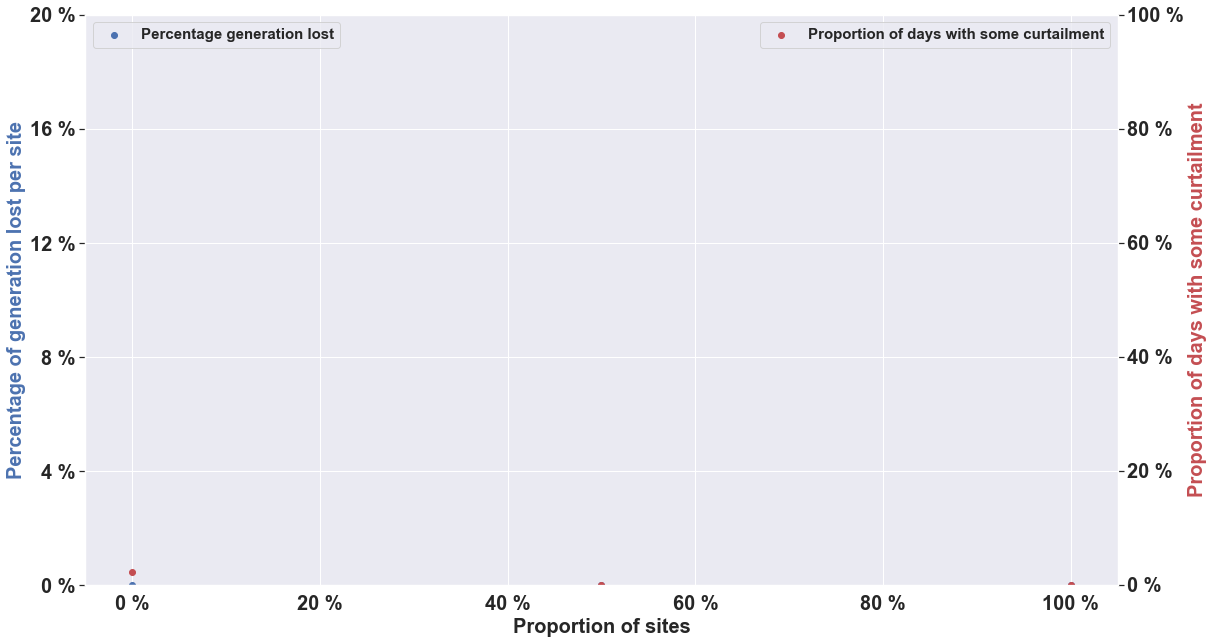

In [125]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax1.scatter(summary['proportion_of_sites'], summary["percentage_of_generation_lost"], color = 'b', 
            label = 'Percentage generation lost')

ax1.set_xlabel('Proportion of sites', **fontdict)
ax1.set_ylabel('Percentage of generation lost per site', **fontdict, color='b')

ax1.set_xticks([0, 20, 40, 60, 80, 100])
ax1.set_xticklabels(['0 %', '20 %', '40 %', '60 %', '80 %', '100 %'], **fontdict)
ax1.set_yticks([0, 4, 8, 12, 16, 20])
ax1.set_yticklabels(['0 %', '4 %', '8 %', '12 %', '16 %', '20 %'], **fontdict)
ax1.legend(loc = 2, prop={'size': 15})

ax2 = ax1.twinx()
ax2.scatter(summary['proportion_of_sites'], summary['proportion of days with curtailment'], color='r',
           label = 'Proportion of days with some curtailment')
ax2.set_ylabel('Proportion of days with some curtailment', color='r', **fontdict)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticklabels(['0 %', '20 %', '40 %', '60 %', '80 %', '100 %'], **fontdict)
ax2.legend(loc = 1, prop={'size': 15})

plt.show()

# MESSY BELOW

In [ ]:

if not size_is_ok:
    print('Cannot analyze this sample due to incomplete data.')
else:
    ghi = pd.read_csv(file_path + ghi_file, index_col = 0)
    ghi.index = pd.to_datetime(ghi.index)
    pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
    data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
    data.set_index('Timestamp', inplace=True)

    c_id = data['c_id'][0]
    date = str(data.index[0])[:10]

    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data, unique_cids)
    data_site = file_processing.resample_in_minute(data_site)

    #check the expected power using polyfit
    data_site, polyfit, is_good_polyfit_quality = polyfit_f.check_polyfit(data_site, ac_cap)
    #data_site, a, is_good_polyfit_quality = check_polyfit_constrained(data_site, ac_cap)

    is_clear_sky_day = clear_sky_day.check_clear_sky_day(date, file_path)
    tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
    energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)